## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This quantum hybrid approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions, specifically a GHZ state.

This implementation uses real hardware execution. In case of simulation with noise, FakeSharebrook is used.

## Implementation (real hardware)

In [72]:
# Create enviroment with conda
#conda create -n myenv python=3.10
# IMPORTANT: Make sure you are on 3.10
%pip install qiskit==1.4.2 qiskit-ibm-runtime qiskit-aer qiskit-machine-learning 'qiskit-machine-learning[sparse]' qiskit-algorithms
%pip install tensorflow
%pip install matplotlib
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [73]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal, RealAmplitudes, EfficientSU2, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, Batch
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

import tensorflow as tf
import copy
import matplotlib.pyplot as plt
import time
import os

In [74]:
# # Configure service
# token = ""
# instance = "ibm-q-ikerbasque/internal/road-to-practiti" # "ibm-q-ikerbasque/internal/road-to-practiti" # "ibm-q-ikerbasque/upv-ehu/implementacin-y-"

# QiskitRuntimeService.save_account(
#     token=token,
#     channel="ibm_quantum",
#     instance=instance,
#     overwrite=True
# )

In [75]:
# Get backend
service = QiskitRuntimeService(channel='ibm_quantum') # Execution in real hardware

backend = service.least_busy(min_num_qubits=30)
#backend = service.backend("ibm_sherbrooke")
#backend = FakeSherbrooke() # Execution in simulator with noise

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

backend

<IBMBackend('ibm_strasbourg')>

In [ ]:
# Number of qubits
REAL_DIST_NQUBITS = 4

draw_circuits = 1

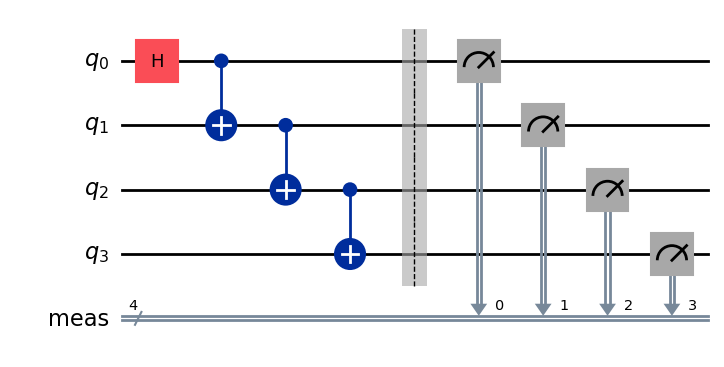

In [77]:
# Create real data circuit
def generate_ghz(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
 
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
        
    # l = int(np.ceil(np.log2(num_qubits)))
    # for m in range(l, 0, -1):
    #     for k in range(0, num_qubits, 2 ** m):
    #         if k + 2 ** (m - 1) >= num_qubits: continue
    #         qc.cx(k, k + 2 ** (m - 1))
    return qc

real_circuit_meas = generate_ghz(REAL_DIST_NQUBITS)
real_circuit_meas.measure_all()
isa_real_circuit_meas = pm.run(real_circuit_meas)

if draw_circuits:
    display(real_circuit_meas.draw('mpl'))

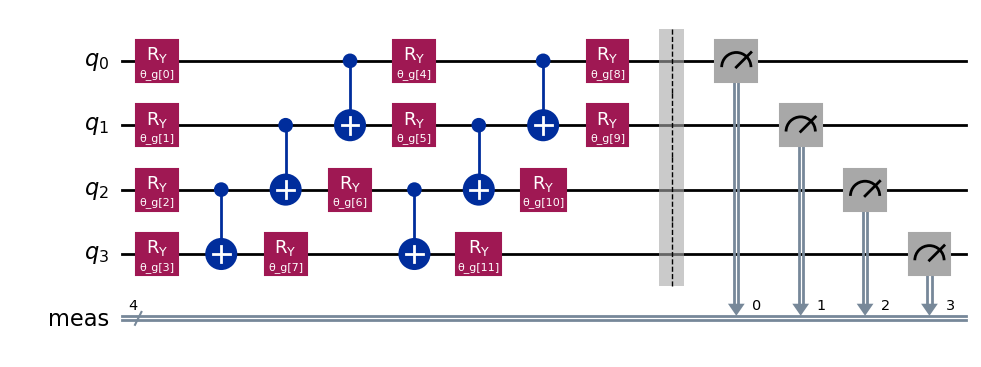

In [78]:
# Create generator

# generator_meas = TwoLocal(REAL_DIST_NQUBITS,
#                      # Parameterized single qubit rotations
#                      ['ry', 'rz'],
#                      'cz',  # Entangling gate
#                      'full', # Entanglement structure: all to all
#                      reps=2, # Number of layers
#                      parameter_prefix='θ_g',
#                      name='Generator')

generator_meas = RealAmplitudes(REAL_DIST_NQUBITS,
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator_meas = generator_meas.decompose()
generator_meas.measure_all()
isa_generator_meas = pm.run(generator_meas)

if draw_circuits:
    display(generator_meas.draw('mpl'))

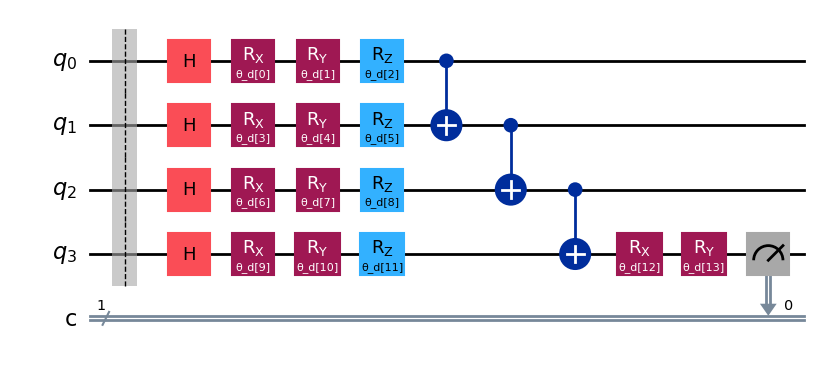

In [79]:
# Create discriminator
def generate_discriminator(num_qubits, disc_weights):
    qc = QuantumCircuit(num_qubits, 1, name="Discriminator")
    param_index = 0

    qc.barrier()

    for q in range(num_qubits):
        qc.h(q)
        qc.rx(disc_weights[param_index], q); param_index += 1
        qc.ry(disc_weights[param_index], q); param_index += 1
        qc.rz(disc_weights[param_index], q); param_index += 1
    
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    # for i in range(num_qubits - 1):
    #     qc.cx(i, num_qubits - 1)
    # l = int(np.ceil(np.log2(num_qubits)))
    # for m in range(1, l+1):
    #     print("m:", m)
    #     for k in range(1, num_qubits, 2 ** m):
    #         print("k:", k)
    #         if k + 2 ** (m - 1) >= num_qubits: continue
    #         qc.cx(k, k + 2 ** (m - 1))

    qc.rx(disc_weights[param_index], num_qubits-1); param_index += 1
    qc.ry(disc_weights[param_index], num_qubits-1); param_index += 1
    #qc.rz(disc_weights[param_index], num_qubits-1); param_index += 1
    
    qc.measure(num_qubits-1, 0) # For real hardware execution
    return qc
disc_weights = ParameterVector('θ_d', 3*(REAL_DIST_NQUBITS)+2)
discriminator_meas = generate_discriminator(REAL_DIST_NQUBITS, disc_weights)

if draw_circuits: 
    display(discriminator_meas.draw('mpl'))

In [80]:
# Parameters
N_GPARAMS = generator_meas.num_parameters
N_DPARAMS = discriminator_meas.num_parameters
N_GPARAMS, N_DPARAMS

(12, 14)

In [81]:
# Connect real data and discriminator
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)

real_circuit = generate_ghz(REAL_DIST_NQUBITS)
real_disc_circuit.compose(real_circuit, inplace=True) # Real data circuit without measurement

real_disc_circuit.compose(discriminator_meas, inplace=True)

isa_real_disc_circuit = pm.run(real_disc_circuit)

In [82]:
# Connect generator and discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)

generator = RealAmplitudes(REAL_DIST_NQUBITS,
                     reps=2, 
                     parameter_prefix='θ_g',
                     name='Generator')
gen_disc_circuit.compose(generator, inplace=True) # Generator without measurements

gen_disc_circuit.compose(discriminator_meas, inplace=True)

isa_gen_disc_circuit = pm.run(gen_disc_circuit)

In [83]:
# Cost calculation functions

def generator_cost(gen_params):    
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    gendisc_bound = isa_gen_disc_circuit.assign_parameters(curr_params)
    # Run circuit using the sampler
    job = sampler.run([gendisc_bound])
    result = job.result()
    # Get counts
    gendisc_counts = result[0].data.c.get_bitstrings()
    # Get counts that measured |1> on q2
    gendisc_q2_counts = [b for b in gendisc_counts if b == '1']
    # Get total prob of measuring |1> on q2
    prob_fake_true = len(gendisc_q2_counts) / len(gendisc_counts)
    cost = -prob_fake_true
    return cost

def discriminator_cost(disc_params):
    # .numpy() method extracts numpy array from TF tensor
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    # Assign parameters to both circuits
    gendisc_bound = isa_gen_disc_circuit.assign_parameters(curr_params)
    realdisc_bound = isa_real_disc_circuit.assign_parameters(disc_params.numpy())
    # Run both circuits using the sampler
    job = sampler.run([gendisc_bound, realdisc_bound])
    result = job.result()
    # Get counts for both circuits
    gendisc_counts = result[0].data.c.get_bitstrings()
    realdisc_counts = result[1].data.c.get_bitstrings()
    # Get counts that measured |1> on q2
    gendisc_q2_counts = [b for b in gendisc_counts if b == '1']
    realdisc_q2_counts = [b for b in realdisc_counts if b == '1']
    # Get total prob of measuring |1> on q2
    prob_fake_true = len(gendisc_q2_counts) / len(gendisc_counts)
    prob_real_true = len(realdisc_q2_counts) / len(realdisc_counts)
    cost = prob_fake_true - prob_real_true
    return cost

In [84]:
# Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions

def calculate_kl_div(model_counts: dict, target_counts: dict):
    kl_div = 0
    for bitstring, data in target_counts.items():
        p_data = data / sum(target_counts.values())
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_counts.keys():
            p_model = model_counts[bitstring] / sum(model_counts.values())
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(p_model))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [85]:
# Use SamplerQNN to compile the parameterized circuit and handle calculation of the gradient recipes.

# sampler = Sampler(mode=backend)

# gradient = ParamShiftSamplerGradient(sampler=sampler)

# # specify QNN to update generator weights
# gen_qnn = SamplerQNN(circuit=gen_disc_circuit,  # parameterized circuit
#                      # frozen input arguements (discriminator weights)
#                      input_params=gen_disc_circuit.parameters[:N_DPARAMS],
#                      # differentiable weights (generator weights)
#                      weight_params=gen_disc_circuit.parameters[N_DPARAMS:],
#                      sparse=True, # returns sparse probability vector
#                      sampler=sampler,
#                      pass_manager=pm,
#                      gradient=gradient)

# # specify QNNs to update discriminator weights regarding to fake data
# disc_fake_qnn = SamplerQNN(circuit=gen_disc_circuit, # parameterized circuit
#                            # frozen input arguments (generator weights)
#                            input_params=gen_disc_circuit.parameters[N_DPARAMS:],
#                            # differentiable weights (discrim. weights)
#                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
#                            sparse=True, # get sparse probability vector
#                            sampler=sampler,
#                            pass_manager=pm,
#                            gradient=gradient)

# # specify QNNs to update discriminator weights regarding to real data
# disc_real_qnn = SamplerQNN(circuit=real_disc_circuit, # parameterized circuit
#                            input_params=[], # no input parameters
#                            # differentiable weights (discrim. weights)
#                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
#                            sparse=True, # get sparse probability vector
#                            sampler=sampler,
#                            pass_manager=pm,
#                            gradient=gradient)

In [86]:
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))

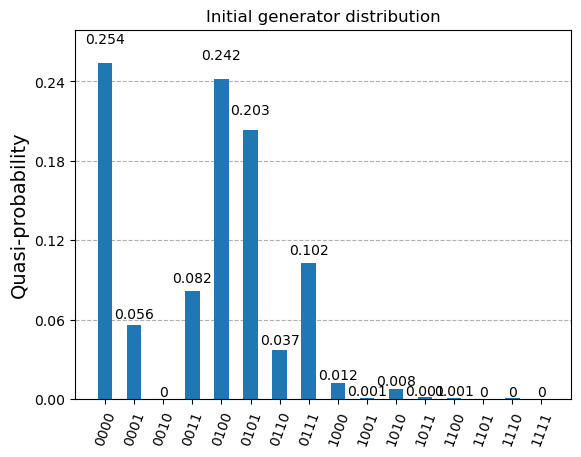

In [87]:
# Display initial generator distribution
if draw_circuits:
    init_gen_circuit = generator.assign_parameters(init_gen_params)
    init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial generator distribution")
    plot_histogram(init_prob_dict, ax=ax1)

In [88]:
# Initialize Adam optimizer from Keras (TensorFlow)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [89]:
def initialize_parameters(reset, data_folder_name="data", training_data_file_name='training_data_hr', parameter_data_file_name='parameters_hr'):
    data_folder_name += '/'
    if not os.path.exists(data_folder_name):
        os.mkdir(data_folder_name) # Create data folder

    training_data_file = data_folder_name + training_data_file_name + '_q' + str(REAL_DIST_NQUBITS) + '.txt'
    parameter_data_file = data_folder_name + parameter_data_file_name + '_q' + str(REAL_DIST_NQUBITS) + '.txt'

    if reset == 1:
        current_epoch = 0
        gloss, dloss, kl_div = [], [], []

        gen_params = tf.Variable(init_gen_params)
        disc_params = tf.Variable(init_disc_params)
        best_gen_params = tf.Variable(init_gen_params)

        file = open(training_data_file,'w')

    else:
        try:
            with open(training_data_file) as f: # Load training data
                lines = f.read().splitlines()
        except FileNotFoundError:
            print("Training data file not found. Resetting parameters.")
            return initialize_parameters(1, data_folder_name, training_data_file_name, parameter_data_file_name)
        current_epoch = len(lines)
        gloss, dloss, kl_div = [], [], []
        for line in lines:
            line_data = line.split(";")
            if len(line_data) != 4:
                print("Error in training_data.txt file in line:", line)
            gloss.append(np.float64(line_data[1]))
            dloss.append(np.float64(line_data[2]))
            kl_div.append(np.float64(line_data[3]))

        try:
            with open(parameter_data_file) as f: # Load parameters
                line = f.readline()
        except FileNotFoundError:
            print("ERROR: Parameter data file not found, even though training data file exists.")
        line_data = line.split(";")
        if len(line_data) != 3:
            print("Error in parameters.txt file")
        gen_params = tf.Variable(np.array(eval(line_data[0])).astype(float))
        disc_params = tf.Variable(np.array(eval(line_data[1])).astype(float))
        best_gen_params = tf.Variable(np.array(eval(line_data[2])).astype(float))

        file = open(training_data_file,'a')

    return current_epoch, gloss, dloss, kl_div, gen_params, disc_params, best_gen_params, file, parameter_data_file

In [90]:
# Training

#--- Initialize parameters ---#
max_epoch = 10
reset = 1 # Continue training from last execution

current_epoch, gloss, dloss, kl_div, gen_params, disc_params, best_gen_params, file, parameter_data_file = initialize_parameters(reset)


#--- Initialize optimizers with loaded parameters ---#
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    
try: # In case of interruption
    with Session(backend=backend) as session:
        sampler = Sampler(mode=session)
        sampler.options.default_shots = 10000

        estimator = Estimator(mode=session)

        gradient = ParamShiftEstimatorGradient(estimator=estimator)

        # specify QNN to update generator weights
        gen_qnn = EstimatorQNN(circuit=gen_disc_circuit,  # parameterized circuit
                            # frozen input arguements (discriminator weights)
                            input_params=gen_disc_circuit.parameters[:N_DPARAMS],
                            # differentiable weights (generator weights)
                            weight_params=gen_disc_circuit.parameters[N_DPARAMS:],
                            estimator=estimator,
                            pass_manager=pm,
                            #gradient=gradient
                            )


        # specify QNNs to update discriminator weights
        disc_fake_qnn = EstimatorQNN(circuit=gen_disc_circuit, # parameterized circuit
                                # frozen input arguments (generator weights)
                                input_params=gen_disc_circuit.parameters[N_DPARAMS:],
                                # differentiable weights (discrim. weights)
                                weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                                estimator=estimator,
                                pass_manager=pm,
                                #gradient=gradient
                                )

        disc_real_qnn = EstimatorQNN(circuit=real_disc_circuit, # parameterized circuit
                                input_params=[], # no input parameters
                                # differentiable weights (discrim. weights)
                                weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                                estimator=estimator,
                                pass_manager=pm,
                                #gradient=gradient
                                )

        TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
        print(TABLE_HEADERS)
        start_time = time.time()

        #--- Training loop ---#
        for epoch in range(current_epoch, max_epoch):

            #--- Quantum discriminator parameter updates ---#
            D_STEPS = 1 # N discriminator updates per generator update
            for disc_train_step in range(D_STEPS):
                grad_dcost_fake = disc_fake_qnn.backward(gen_params, disc_params)[1][0,0]
                grad_dcost_real = disc_real_qnn.backward([], disc_params)[1][0,0]
                grad_dcost = grad_dcost_real - grad_dcost_fake
                grad_dcost = tf.convert_to_tensor(grad_dcost)
                
                discriminator_optimizer.apply_gradients(zip([grad_dcost], [disc_params]))
                
                if disc_train_step % D_STEPS == 0:
                    dloss.append(discriminator_cost(disc_params))

            #--- Quantum generator parameter updates ---#
            for gen_train_step in range(1):
                grad_gcost = gen_qnn.backward(disc_params, gen_params)[1][0,0]
                grad_gcost = tf.convert_to_tensor(grad_gcost)

                generator_optimizer.apply_gradients(zip([grad_gcost], [gen_params]))
                gloss.append(generator_cost(gen_params))

            #--- Track KL and save best performing generator weights ---#
            # Create test circuit with updated gen parameters
            gen_checkpoint_circuit = isa_generator_meas.assign_parameters(gen_params.numpy()) # Create test circuit with updated gen parameters
            job = sampler.run([gen_checkpoint_circuit, isa_real_circuit_meas]) #Retrieve probability distribution of current generator and probability distribution of real data
            result = job.result()

            # Get counts for both circuits
            gendisc_counts = result[0].data.meas.get_counts()
            realdisc_counts = result[1].data.meas.get_counts()

            current_kl = calculate_kl_div(gendisc_counts, realdisc_counts)
            kl_div.append(current_kl)
            if np.min(kl_div) == current_kl:
                best_gen_params = copy.deepcopy(gen_params) # New best

            #--- Save progress in file ---#
            file.write(str(epoch) + ";" + str(gloss[-1]) + ";" + str(dloss[-1]) + ";" + str(kl_div[-1]) + "\n")

            if epoch % 1 == 0: # Print progress
                for header, val in zip(TABLE_HEADERS.split('|'),
                                    (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                    print(f"{val:.3g} ".rjust(len(header)), end="|")
                start_time = time.time()
                print()
                
#--- Save data in file ---#
finally:
    file.close()
    file = open(parameter_data_file,'w')
    file.write(str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
    file.close()
        
print("Training complete.")

Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |


/home/benat/miniconda3/envs/qiskit-ibm/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:857: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


    0 |         -0.567 |             0.0053 |    2.13 |         2.13 |  238 |
    1 |         -0.569 |            -0.0167 |    2.53 |         2.13 |  236 |
    2 |         -0.563 |            -0.0262 |    2.43 |         2.13 |  246 |
    3 |         -0.547 |             -0.025 |    2.07 |         2.07 |  234 |
    4 |         -0.553 |            -0.0092 |    1.96 |         1.96 |  247 |
    5 |         -0.552 |            -0.0251 |    2.31 |         1.96 |  254 |
    6 |         -0.562 |            -0.0158 |    1.89 |         1.89 |  239 |
    7 |         -0.566 |            -0.0092 |     2.6 |         1.89 |  248 |
    8 |         -0.558 |            -0.0152 |     2.2 |         1.89 |  235 |
    9 |         -0.568 |            -0.0132 |    2.32 |         1.89 |  229 |
Training complete.


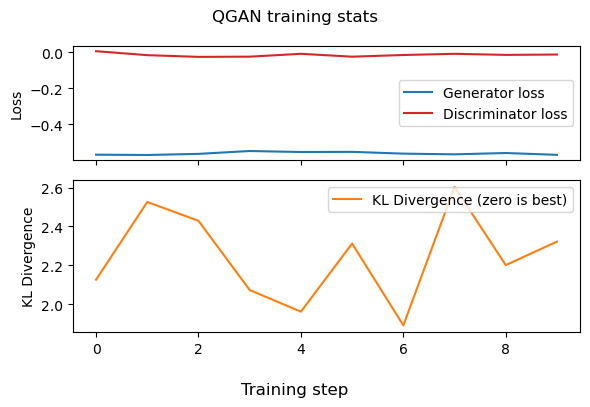

In [93]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout()

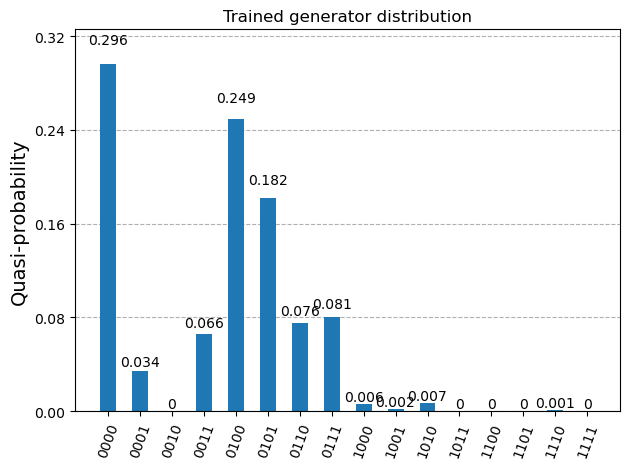

In [92]:
# Create test circuit with new parameters
if draw_circuits:
    gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())
    gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
    real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
    #fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,3))
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    plot_histogram(gen_prob_dict, ax=ax1)
    ax1.set_title("Trained generator distribution")
    #plot_histogram(real_prob_dict, ax=ax2)
    #ax2.set_title("Real distribution")
    fig.tight_layout()